<a href="https://colab.research.google.com/github/SaranshRegmi10/BrainTumor_Segmentation/blob/main/Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2025/05/19 -- 05/20 -- 05/21 -- 05/22

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import gc
import nibabel as nb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate, Input
from tensorflow.keras.models import Model,load_model
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import kagglehub
import os

In [3]:
# Download latest version
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")

print("Path to dataset files:", path)
print(os.listdir(path))

100%|██████████| 4.16G/4.16G [01:45<00:00, 42.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1
['BraTS2020_ValidationData', 'BraTS2020_TrainingData']


In [4]:
dir_path = "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
base_path = os.path.join(path, dir_path)

mobilities = ['t1', 't2', 'flair', 't1ce']

X_data = []
Y_data = []

max_subjects = 50  # limit max subjects to avoid memory overflow (adjust as needed)
subject_count = 0

for subject_folder in os.listdir(base_path):
    if subject_count >= max_subjects:
        break

    subject_path = os.path.join(base_path, subject_folder)
    if not os.path.isdir(subject_path) or not subject_folder.startswith("BraTS20_Training_"):
        continue

    try:
        # Load all modalities with float32 to save memory
        vols = {}
        for mod in mobilities:
            file_path = os.path.join(subject_path, f"{subject_folder}_{mod}.nii")
            vols[mod] = nb.load(file_path).get_fdata().astype(np.float32)

        mask_path = os.path.join(subject_path, f"{subject_folder}_seg.nii")
        seg = nb.load(mask_path).get_fdata().astype(np.float32)

        # Only process slices with tumors (skip empty slices)
        for slice_index in range(60, 91):
            mask_slice = seg[:, :, slice_index]
            if np.max(mask_slice) == 0:
                continue

            channels = []
            for mod in mobilities:
                slice_ = vols[mod][:, :, slice_index]
                resized = cv2.resize(slice_, (128, 128))
                norm = (resized - np.min(resized)) / (np.max(resized) - np.min(resized) + 1e-8)
                channels.append(norm)

            x = np.stack(channels, axis=-1)

            mask_resized = cv2.resize(mask_slice, (128, 128), interpolation=cv2.INTER_NEAREST)
            y = (mask_resized > 0).astype(np.float32)[..., np.newaxis]

            X_data.append(x)
            Y_data.append(y)

        # Clear big variables manually to free RAM
        del vols, seg
        gc.collect()

        subject_count += 1
        # print(f"Processed {subject_count} subjects")

    except Exception as e:
        print(f"Skipping {subject_folder}: {e}")

# Convert lists to numpy arrays with float32 dtype
X_data = np.array(X_data, dtype=np.float32)
Y_data = np.array(Y_data, dtype=np.float32)

print("Final shapes:", X_data.shape, Y_data.shape)

Final shapes: (1359, 128, 128, 4) (1359, 128, 128, 1)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

#U-Net

In [7]:
def unet_model(hp):
    inputs = Input(shape=(128, 128, 4))

    # Tune dropout
    dropout_rate = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)

    # Tune number of filters
    f1 = hp.Choice('filters_layer1', values=[16, 32, 64])

    # Encoder
    c1 = Conv2D(f1, 3, activation='relu', padding='same')(inputs)
    c1 = Dropout(dropout_rate)(c1)
    c1 = Conv2D(f1, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    f2 = f1 * 2
    c2 = Conv2D(f2, 3, activation='relu', padding='same')(p1)
    c2 = Dropout(dropout_rate)(c2)
    c2 = Conv2D(f2, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    f3 = f2 * 2
    c3 = Conv2D(f3, 3, activation='relu', padding='same')(p2)
    c3 = Dropout(dropout_rate)(c3)
    c3 = Conv2D(f3, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    # Bottleneck
    f4 = f3 * 2
    c4 = Conv2D(f4, 3, activation='relu', padding='same')(p3)
    c4 = Dropout(dropout_rate)(c4)
    c4 = Conv2D(f4, 3, activation='relu', padding='same')(c4)

    # Decoder
    u1 = Conv2DTranspose(f3, 2, strides=2, padding='same')(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(f3, 3, activation='relu', padding='same')(u1)
    c5 = Conv2D(f3, 3, activation='relu', padding='same')(c5)

    u2 = Conv2DTranspose(f2, 2, strides=2, padding='same')(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(f2, 3, activation='relu', padding='same')(u2)
    c6 = Conv2D(f2, 3, activation='relu', padding='same')(c6)

    u3 = Conv2DTranspose(f1, 2, strides=2, padding='same')(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(f1, 3, activation='relu', padding='same')(u3)
    c7 = Conv2D(f1, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])

    # Tune learning rate
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [8]:
tuner = kt.RandomSearch(
    unet_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
)

In [9]:
tuner.search(X_train, y_train, epochs=5, validation_split=0.2)

Trial 5 Complete [00h 01m 40s]
val_accuracy: 0.9688678979873657

Best val_accuracy So Far: 0.9729630947113037
Total elapsed time: 00h 07m 12s


In [10]:
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [12]:
best_learning_rate = best_hps.get('learning_rate')
best_dropout = best_hps.get('dropout')
print(f"Best dropout: {best_dropout}")
print(f"Best learning rate: {best_learning_rate}")

Best dropout: 0.2
Best learning rate: 0.0001


In [19]:
def unet_final_model(learning_rate,dropout_rate):

  input = Input((128,128,4))

  #Encoder
  c1 = Conv2D(16,(3,3),activation="relu",padding="same")(input)
  c1 = Dropout(best_dropout)(c1)
  c1 = Conv2D(16,(3,3),activation="relu",padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32,(3,3),activation="relu",padding= "same")(p1)
  c2 = Dropout(best_dropout)(c2)
  c2 = Conv2D(32,(3,3),activation="relu",padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64,(3,3),activation="relu",padding="same")(p2)
  c3 = Dropout(best_dropout)(c3)
  c3 = Conv2D(64,(3,3),activation="relu",padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128,(3,3),activation="relu",padding="same")(p3)
  c4 = Dropout(best_dropout)(c4)
  c4 = Conv2D(128,(3,3),activation="relu",padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  #Bottlefask
  c5 = Conv2D(256,(3,3),activation="relu",padding="same")(p4)
  c5 = Dropout(best_dropout)(c5)
  c5 = Conv2D(256,(3,3),activation="relu",padding="same")(c5)

  #Decoder
  u1 = Conv2DTranspose(128,(2,2),strides=(2,2),padding="same")(c5)
  u1 = concatenate([u1,c4])
  c6 = Conv2D(128,(3,3),activation="relu",padding="same")(u1)

  u2 = Conv2DTranspose(64,(2,2),strides=(2,2),padding="same")(c6)
  u2 = concatenate([u2,c3])
  c7 = Conv2D(64,(3,3),activation="relu",padding="same")(u2)

  u3 = Conv2DTranspose(32,(2,2),strides=(2,2),padding="same")(c7)
  u3 = concatenate([u3,c2])
  c8 = Conv2D(32,(3,3),activation="relu",padding="same")(u3)

  u4 = Conv2DTranspose(16,(2,2),strides=(2,2),padding="same")(c8)
  u4 = concatenate([u4,c1])
  c9 = Conv2D(16,(3,3),activation="relu",padding="same")(u4)

  output = Conv2D(1,(1,1),activation="sigmoid")(c9)

  model = Model(inputs=input,outputs=output )
  model.compile(optimizer=Adam(learning_rate=best_learning_rate),loss="binary_crossentropy",metrics=["accuracy", dice_coefficient, iou_metric])

  return model

In [14]:
model = unet_final_model(
  learning_rate = best_learning_rate,
  dropout_rate = best_dropout
)

In [15]:
fitting = model.fit(X_train,y_train,validation_split=0.2,batch_size=8,epochs=20)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - accuracy: 0.8274 - loss: 0.5413 - val_accuracy: 0.9689 - val_loss: 0.2513
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.9687 - loss: 0.1023 - val_accuracy: 0.9689 - val_loss: 0.1734
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9721 - loss: 0.0735 - val_accuracy: 0.9691 - val_loss: 0.1051
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9841 - loss: 0.0445 - val_accuracy: 0.9804 - val_loss: 0.0795
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9855 - loss: 0.0387 - val_accuracy: 0.9803 - val_loss: 0.0654
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9871 - loss: 0.0346 - val_accuracy: 0.9720 - val_loss: 0.0722
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9876 - loss: 0.0326 - val_accuracy: 0.9826 - val_loss: 0.0501
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9884 - loss: 0.0305 - val_a

In [21]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [16]:
print("Saving model...")
model.save('model.h5')
print("Model saved as 'model.h5'")

💾 Saving model...
✅ Model saved as 'model.h5'


In [22]:
print("\n📊 Evaluating on test data...")
test_results = model.evaluate(X_test, y_test, verbose=1)


📊 Evaluating on test data...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9804 - loss: 0.0470


In [25]:
if len(test_results) >= 4:
    print(f" Test Loss: {test_results[0]:.4f}")
    print(f" Test Accuracy: {test_results[1]:.4f}")
    print(f" Test Dice Coefficient: {test_results[2]:.4f}")
    print(f" Test IoU: {test_results[3]:.4f}")
else:
    print(f" Test Loss: {test_results[0]:.4f}")
    print(f" Test Accuracy: {test_results[1]:.4f}")
    print("  Custom metrics not available - calculating manually...")
    test_preds = model.predict(X_test, verbose=0)

    def calculate_dice_iou(y_true, y_pred, threshold=0.5):
        y_pred_binary = (y_pred > threshold).astype(np.float32)
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred_binary.flatten()

        intersection = np.sum(y_true_flat * y_pred_flat)
        union = np.sum(y_true_flat) + np.sum(y_pred_flat) - intersection

        dice = (2. * intersection + 1e-6) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + 1e-6)
        iou = (intersection + 1e-6) / (union + 1e-6)

        return dice, iou

    manual_dice, manual_iou = calculate_dice_iou(y_test, test_preds)
    print(f" Test Dice Coefficient: {manual_dice:.4f}")
    print(f" Test IoU: {manual_iou:.4f}")

 Test Loss: 0.0480
 Test Accuracy: 0.9798
  Custom metrics not available - calculating manually...
 Test Dice Coefficient: 0.7494
 Test IoU: 0.5992


In [27]:
print("\nMaking predictions...")
n = 10  # Number of samples to visualize
preds = model.predict(X_data[:n])
preds_thresholded = (preds > 0.5).astype(np.uint8)


Making predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


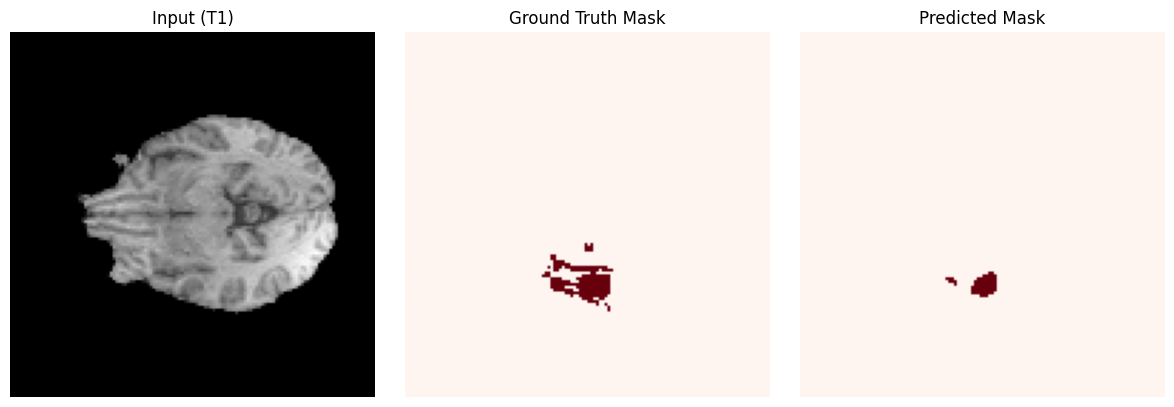

Sample result saved as 'segmentation_result.png'


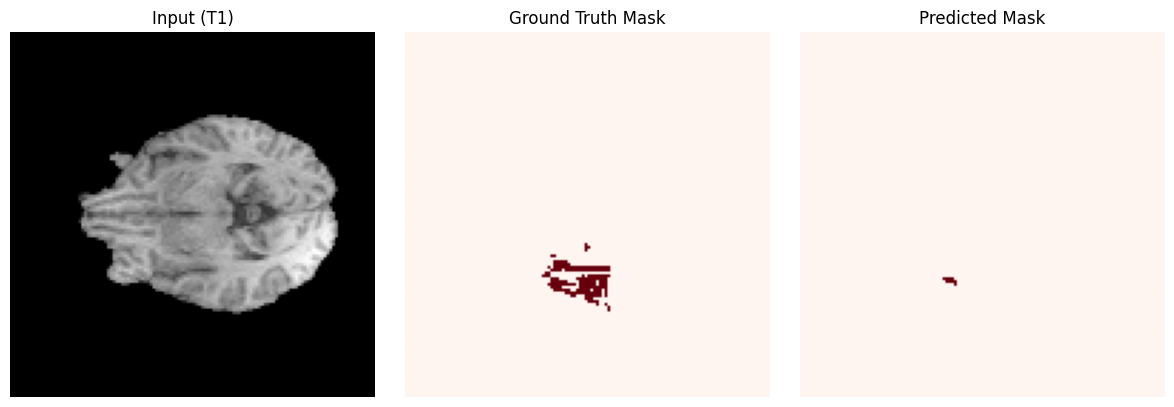

Sample result saved as 'segmentation_result.png'


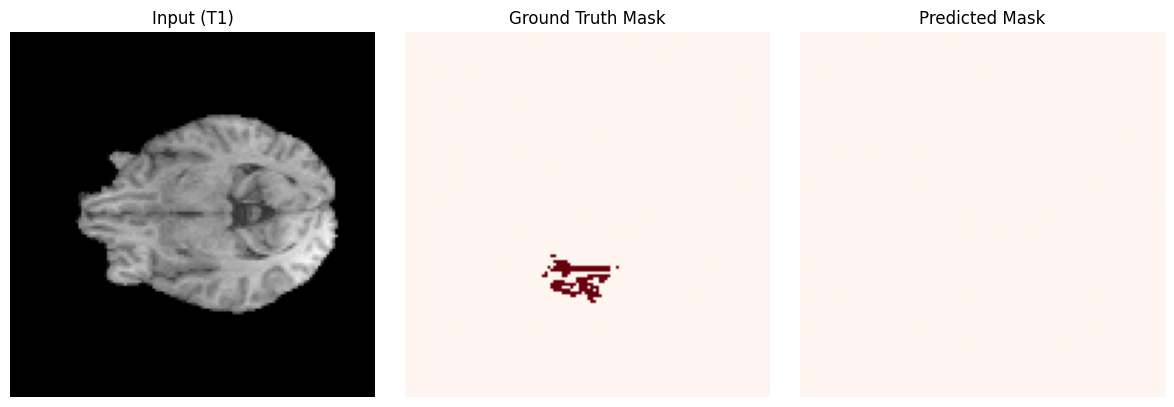

Sample result saved as 'segmentation_result.png'


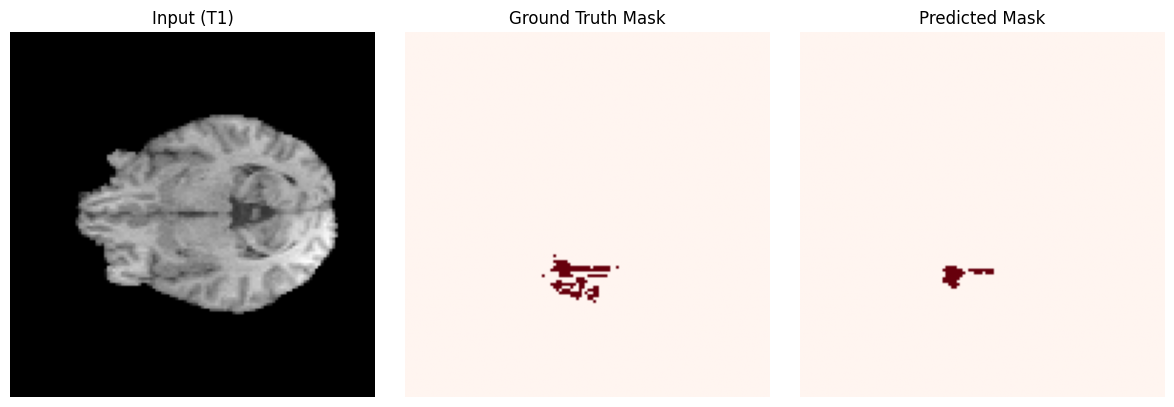

Sample result saved as 'segmentation_result.png'


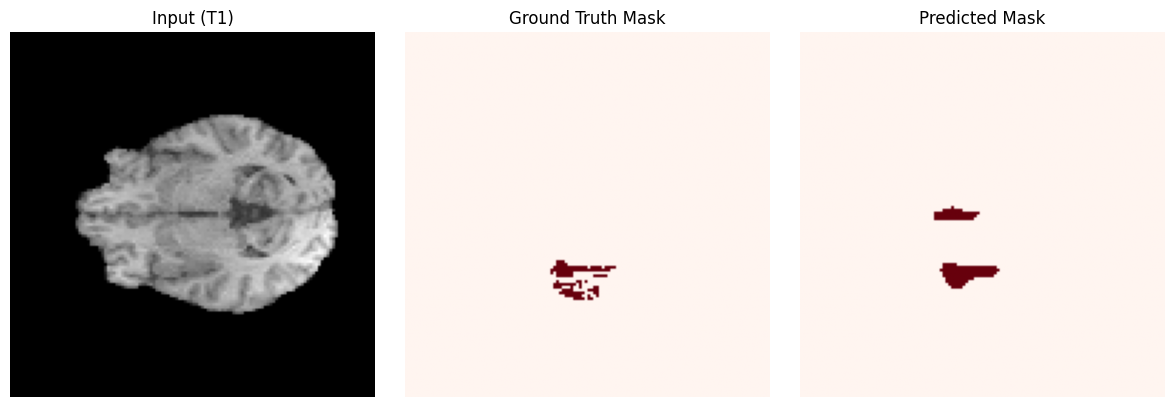

Sample result saved as 'segmentation_result.png'


In [32]:
for i in range(min(n, 5)):  # Show first 5 samples
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Input image (first channel - T1)
    axs[0].imshow(X_data[i][:, :, 0], cmap='gray')
    axs[0].set_title("Input (T1)")
    axs[0].axis('off')

    # Ground Truth
    axs[1].imshow(Y_data[i][:, :, 0], cmap='Reds')
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis('off')

    # Prediction
    axs[2].imshow(preds_thresholded[i][:, :, 0], cmap='Reds')
    axs[2].set_title("Predicted Mask")
    axs[2].axis('off')


    plt.tight_layout()
    plt.savefig("segmentation_result.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("Sample result saved as 'segmentation_result.png'")

Available training metrics: ['accuracy', 'loss', 'val_accuracy', 'val_loss']


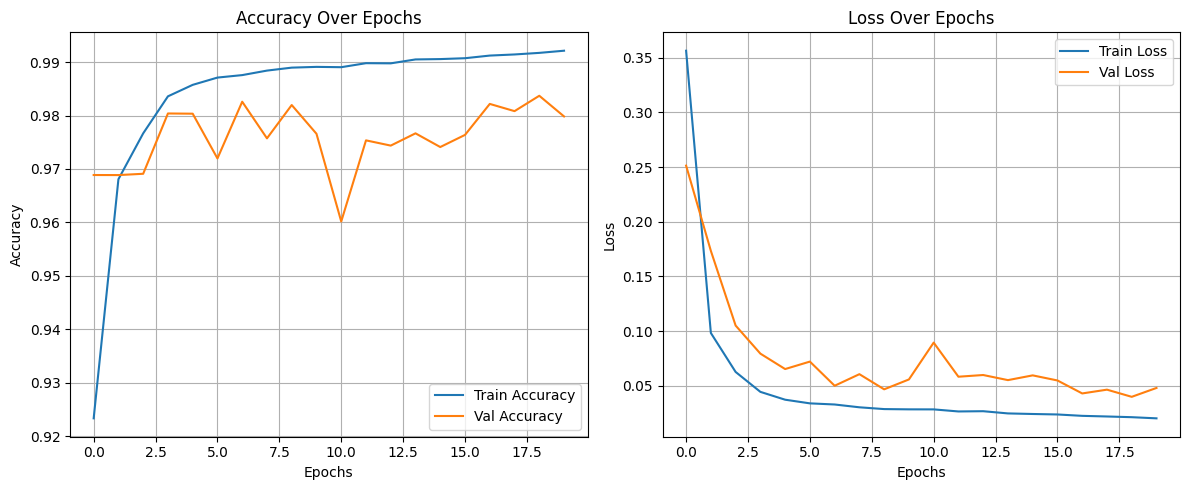

✅ Training plots saved as 'training_metrics.png'


In [30]:
available_metrics = list(fitting.history.keys())
print(f"Available training metrics: {available_metrics}")

# Create plots based on available metrics
if 'dice_coefficient' in available_metrics and 'iou_metric' in available_metrics:
    # Full plot with all metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(fitting.history['accuracy'], label='Train Accuracy')
    axes[0, 0].plot(fitting.history['val_accuracy'], label='Val Accuracy')
    axes[0, 0].set_xlabel("Epochs")
    axes[0, 0].set_ylabel("Accuracy")
    axes[0, 0].set_title("Accuracy Over Epochs")
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(fitting.history['loss'], label='Train Loss')
    axes[0, 1].plot(fitting.history['val_loss'], label='Val Loss')
    axes[0, 1].set_xlabel("Epochs")
    axes[0, 1].set_ylabel("Loss")
    axes[0, 1].set_title("Loss Over Epochs")
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Dice Coefficient
    axes[1, 0].plot(fitting.history['dice_coefficient'], label='Train Dice')
    axes[1, 0].plot(fitting.history['val_dice_coefficient'], label='Val Dice')
    axes[1, 0].set_xlabel("Epochs")
    axes[1, 0].set_ylabel("Dice Coefficient")
    axes[1, 0].set_title("Dice Coefficient Over Epochs")
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # IoU
    axes[1, 1].plot(fitting.history['iou_metric'], label='Train IoU')
    axes[1, 1].plot(fitting.history['val_iou_metric'], label='Val IoU')
    axes[1, 1].set_xlabel("Epochs")
    axes[1, 1].set_ylabel("IoU")
    axes[1, 1].set_title("IoU Over Epochs")
    axes[1, 1].legend()
    axes[1, 1].grid(True)

else:
    # Simple plot with only accuracy and loss
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy
    axes[0].plot(fitting.history['accuracy'], label='Train Accuracy')
    axes[0].plot(fitting.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Accuracy Over Epochs")
    axes[0].legend()
    axes[0].grid(True)

    # Loss
    axes[1].plot(fitting.history['loss'], label='Train Loss')
    axes[1].plot(fitting.history['val_loss'], label='Val Loss')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Loss Over Epochs")
    axes[1].legend()
    axes[1].grid(True)

plt.tight_layout()
plt.savefig("training_metrics.png", dpi=150, bbox_inches='tight')
plt.show()
print("Training plots saved as 'training_metrics.png'")

In [33]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>